# Setup

In [1]:
import os
import gc
import re

from sklearn.model_selection import train_test_split
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colored import fg, bg, attr

from tqdm import tqdm

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.multiprocessing import Pipe, Process
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler

from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from transformers import RobertaModel, RobertaTokenizer

from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from imblearn.over_sampling import RandomOverSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from datetime import datetime

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer 

import torch
import torch.nn as nn
from transformers import AutoModel

import random
import time

import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

In [2]:
hdf = pd.read_csv('happy_submissions.csv')
sdf = pd.read_csv('sad_submissions.csv')

In [3]:
sdf.isna().mean()

author         0.00000
title          0.00001
created_utc    0.00000
score          0.00000
dtype: float64

In [4]:
sdf.dropna(inplace=True)

In [5]:
#Create a function to clean the tweets
def cleanTxt(text):
 text = re.sub(r'@[A-Za-z0–9]+', '', text) #Remove @mentions replace with blank
 text = re.sub(r'#', '', text) #Remove the '#' symbol, replace with blank
 text = re.sub(r'RT[\s]+', '', text) #Removing RT, replace with blank
 text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlinks
 text = re.sub(r':', '', text) # Remove :
 return text
#Cleaning the text
sdf['title']= sdf['title'].apply(cleanTxt)
hdf['title']= hdf['title'].apply(cleanTxt)

In [6]:
#Next we have to remove emoji & Unicode from the Tweet data.
def remove_emoji(string):
 emoji_pattern = re.compile("["
 u"\U0001F600-\U0001F64F" # emoticons
 u"\U0001F300-\U0001F5FF" # symbols & pictographs
 u"\U0001F680-\U0001F6FF" # transport & map symbols
 u"\U0001F1E0-\U0001F1FF" # flags (iOS)
 u"\U00002500-\U00002BEF" # chinese char
 u"\U00002702-\U000027B0"
 u"\U00002702-\U000027B0"
 u"\U000024C2-\U0001F251"
 u"\U0001f926-\U0001f937"
 u"\U00010000-\U0010ffff"
 u"\u2640-\u2642"
 u"\u2600-\u2B55"
 u"\u200d"
 u"\u23cf"
 u"\u23e9"
 u"\u231a"
 u"\ufe0f" # dingbats
 u"\u3030"
 "]+", flags=re.UNICODE)
 return emoji_pattern.sub(r'', string)
#Cleaning the text
sdf['title']= sdf['title'].apply(remove_emoji)
hdf['title']= hdf['title'].apply(remove_emoji)

In [7]:
sdf = sdf[~(sdf.title == '[deleted by user]')]
hdf = hdf[~(hdf.title == '[deleted by user]')]

In [8]:
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment_result(sent):
    scores = analyzer.polarity_scores(sent)
    
    if scores["neg"] > scores["pos"]:
        return 0
    if scores["neg"] == scores["pos"]:
        return 1

    return 2

sdf["sentiment"] = sdf["title"].apply(lambda x: vader_sentiment_result(x))
hdf["sentiment"] = hdf["title"].apply(lambda x: vader_sentiment_result(x))

In [9]:
hdf['sentiment'].value_counts()

sentiment
2    62723
1    24797
0    11215
Name: count, dtype: int64

In [10]:
sdf['sentiment'].value_counts()

sentiment
0    42698
1    29164
2    22872
Name: count, dtype: int64

In [11]:
neutral_sentiment = pd.concat([hdf[hdf['sentiment'] == 1], sdf[sdf['sentiment'] == 1]])
positive_sentiment = hdf[hdf['sentiment'] == 2]
negative_sentiment = sdf[sdf['sentiment'] == 0]

df = pd.concat([positive_sentiment, negative_sentiment, neutral_sentiment])

In [12]:
# Rename sentiment labels
sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
hdf['sentiment'] = hdf['sentiment'].map(sentiment_labels)
sdf['sentiment'] = sdf['sentiment'].map(sentiment_labels)

In [13]:
# Count the values in each sentiment category for both data frames
hdf_counts = hdf['sentiment'].value_counts()
sdf_counts = sdf['sentiment'].value_counts()

In [14]:
# Count the values in each sentiment category for both data frames
hdf_counts = hdf['sentiment'].value_counts()
sdf_counts = sdf['sentiment'].value_counts()

positive_counts = {"positive_subreddit":hdf_counts['positive'], "negative_subreddit":sdf_counts['positive']}
neutral_counts = {"positive_subreddit":hdf_counts['neutral'], "negative_subreddit":sdf_counts['neutral']}
negative_counts = {"positive_subreddit":hdf_counts['negative'], "negative_subreddit":sdf_counts['negative']}

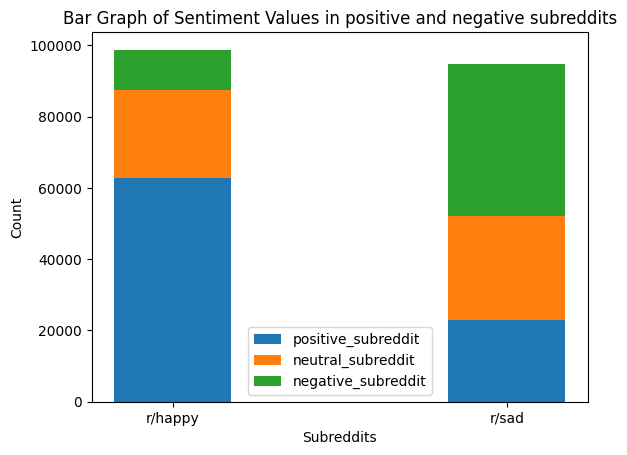

In [15]:
# Create the stacked bar graph
subreddits = ['r/happy', 'r/sad']
width = 0.35
x = range(len(subreddits))

fig, ax = plt.subplots()

bar1 = ax.bar(x, positive_counts.values(), width, label='positive_subreddit')
bar2 = ax.bar(x, neutral_counts.values(), width, label='neutral_subreddit', bottom=np.array(list(positive_counts.values())))
bar3 = ax.bar(x, negative_counts.values(), width, label='negative_subreddit', bottom=np.array(list(positive_counts.values())) + np.array(list(neutral_counts.values())))

# Add labels, title, and legend
ax.set_xlabel('Subreddits')
ax.set_ylabel('Count')
ax.set_title('Bar Graph of Sentiment Values in positive and negative subreddits')
ax.set_xticks(x)
ax.set_xticklabels(subreddits)
ax.legend()

# Show the graph
plt.savefig('sentiments_pos_neg_neut.png')
plt.show()

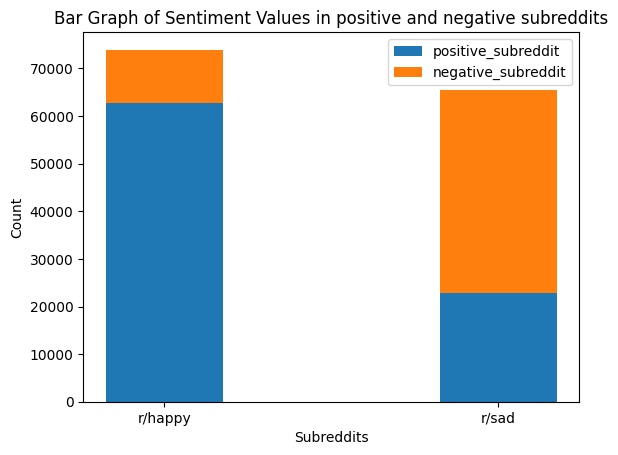

In [16]:
# Create the stacked bar graph
width = 0.35
x = range(len(subreddits))

fig, ax = plt.subplots()

bar1 = ax.bar(x, positive_counts.values(), width, label='positive_subreddit')
bar3 = ax.bar(x, negative_counts.values(), width, label='negative_subreddit', bottom=np.array(list(positive_counts.values())))

# Add labels, title, and legend
ax.set_xlabel('Subreddits')
ax.set_ylabel('Count')
ax.set_title('Bar Graph of Sentiment Values in positive and negative subreddits')
ax.set_xticks(x)
ax.set_xticklabels(subreddits)
ax.legend()

# Show the graph
plt.savefig('sentiments_pos_neg.png')
plt.show()

Text(0.5, 1.0, '# of samples per label class')

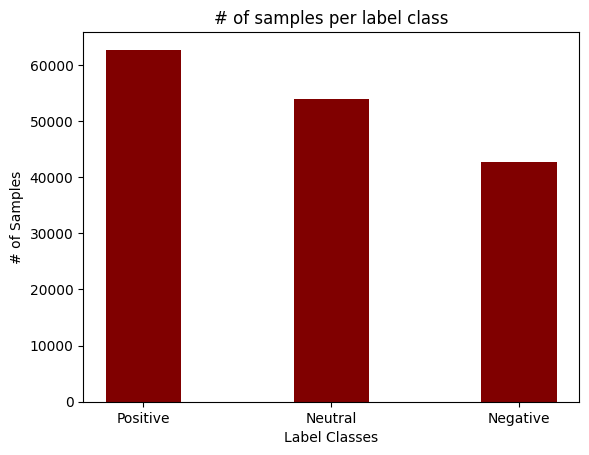

In [17]:
label_count = df['sentiment'].value_counts()

senti = label_count.keys().map({0:"Negative",1:"Neutral", 2:"Positive"})
counts = list(label_count.values)

plt.bar(senti, counts, color ='maroon', width = 0.4)
plt.xlabel("Label Classes")
plt.ylabel("# of Samples")
plt.title("# of samples per label class")

# Sentiment Analysis

### Training and Model declaration

In [18]:
MODEL_PATH_ROOT = 'reddit_sentiment'
MAX_LEN = 256

In [19]:
if torch.backends.mps.is_available():       
    device = torch.device("mps")
    print(f'There is MPS available.')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There is MPS available.


In [25]:
# Create a function to tokenize a set of texts
def preprocessing_for_model(data, tokenizer):
    # Load the BERT tokenizer
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            padding='max_length',           # Pad sentence to max length
            return_attention_mask=True,     # Return attention mask
            truncation=True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

def get_data_loaders(df, model_name, max_len=256, batch_size=16):
        
    df = df.sample(frac=1)
    X = df.title.values
    y = df.sentiment.values
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Run function `preprocessing_for_bert` on the train set and the validation set
    print('Tokenizing data...')
    train_inputs, train_masks = preprocessing_for_model(X_train, tokenizer)
    val_inputs, val_masks = preprocessing_for_model(X_val, tokenizer)
    
    # Convert other data types to torch.Tensor
    train_labels = torch.tensor(y_train)
    val_labels = torch.tensor(y_val)
    
    # Create the DataLoader for our training set
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    
    # Create the DataLoader for our validation set
    val_data = TensorDataset(val_inputs, val_masks, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader, y_val

In [26]:
%%time
# Create the Classifier class
class Classifier(nn.Module):
    """RoBerta Model for Classification Tasks.
    """
    def __init__(self, model_name, hidden_layer_size=768, freeze_model=False):
        """
        @param    model_name (string): model name as stored on hugging face
        @param    hidden_layer_size: size of the hidden layers for that model
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(Classifier, self).__init__()
        # Specify hidden size of model, hidden size of classifier, and number of labels
        D_in, H, D_out = hidden_layer_size, 50, 3

        # Instantiate model
        self.model = AutoModel.from_pretrained(model_name)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the model
        if freeze_model:
            for param in self.model.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to model
        outputs = self.model(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 125 µs, sys: 1 µs, total: 126 µs
Wall time: 133 µs


In [27]:
def initialize_model(model_name, hidden_layer_size, learning_rate=5e-5, epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    classifier = Classifier(model_name, hidden_layer_size, freeze_model=False)

    # Tell PyTorch to run the model on GPU
    classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(classifier.parameters(),
                      lr=learning_rate,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return classifier, optimizer, scheduler

In [28]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the Classifier model.
        """
    # Start training loop
    print(f"Start training with total batches {len(train_dataloader)}\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()
        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        # Put the model into the training mode
        model.train()
        # For each batch of training data...
        for step, batch in enumerate(tqdm(train_dataloader)):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            # Zero out any previously calculated gradients
            model.zero_grad()
            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            # Perform a backward pass to calculate gradients
            loss.backward()
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
            # Print the loss values and time elapsed for every 20 batches
            if (step % 200 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
    
        # Reset batch tracking variables
        batch_loss, batch_counts = 0, 0
        t0_batch = time.time()
        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
            print("\n")

    print("Training complete!")
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
        
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
        on our validation set.
        """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    # Tracking variables
    val_accuracy = []
    val_loss = []
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
            # Compute loss
            loss = loss_fn(logits, b_labels)
            val_loss.append(loss.item())
            # Get the predictions
            preds = torch.argmax(logits, dim=1).flatten()
            # Calculate the accuracy rate
            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

In [29]:
def model_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    all_logits = []
    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
            all_logits.append(logits)
        # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)
    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    return np.argmax(probs, axis=1)

In [30]:
# Compute predicted probabilities on the test set
def display_confusion_matrix(y_pred, y_val):

    # Creating  a confusion matrix,which compares the y_test and y_pred
    cm = confusion_matrix(y_val, y_pred)

    cm_df = pd.DataFrame(cm,
                        index = ['NEGATIVE','NEUTRAL','POSITIVE'], 
                        columns = ['NEGATIVE','NEUTRAL','POSITIVE'])

    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt=',d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [ ]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['title']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1));
df_balanced = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['title', 'sentiment']);
df_balanced = df_balanced.sample(frac=1)

In [ ]:
df_balanced['sentiment'].value_counts()

## Modeling with class Imbalance

### Bert (unbalanced-class)

#### Training

In [235]:
MODEL_NAME = "bert-base-uncased"
HIDDEN_LAYER_SIZE = 768
MODEL_SAVE_PATH = MODEL_PATH_ROOT + '-' + MODEL_NAME + '.pt'

train_dataloader, val_dataloader, y_val = get_data_loaders(df, MODEL_NAME)

set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(MODEL_NAME, HIDDEN_LAYER_SIZE, epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Tokenizing data...
Start training with total batches 8966

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/Users/adityatodi/miniforge3/envs/ds_proj/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/8966 [00:00<?, ?it/s]

   1    |   200   |   0.503961   |     -      |     -     |  108.39  
   1    |   400   |   0.400624   |     -      |     -     |  216.28  
   1    |   600   |   0.357340   |     -      |     -     |  325.44  
   1    |   800   |   0.322542   |     -      |     -     |  433.82  
   1    |  1000   |   0.302279   |     -      |     -     |  542.04  
   1    |  1200   |   0.287524   |     -      |     -     |  650.57  
   1    |  1400   |   0.273170   |     -      |     -     |  759.39  
   1    |  1600   |   0.262905   |     -      |     -     |  868.35  
   1    |  1800   |   0.255049   |     -      |     -     |  977.05  
   1    |  2000   |   0.245262   |     -      |     -     |  1085.57 
   1    |  2200   |   0.235724   |     -      |     -     |  1194.09 
   1    |  2400   |   0.228107   |     -      |     -     |  1302.65 
   1    |  2600   |   0.222967   |     -      |     -     |  1411.17 
   1    |  2800   |   0.217131   |     -      |     -     |  1519.96 
   1    |  3000   | 

  0%|          | 0/8966 [00:00<?, ?it/s]

   2    |   200   |   0.066847   |     -      |     -     |  109.25  
   2    |   400   |   0.060000   |     -      |     -     |  217.65  
   2    |   600   |   0.056459   |     -      |     -     |  326.16  
   2    |   800   |   0.060480   |     -      |     -     |  434.58  
   2    |  1000   |   0.056806   |     -      |     -     |  543.29  
   2    |  1200   |   0.056993   |     -      |     -     |  651.79  
   2    |  1400   |   0.055192   |     -      |     -     |  760.17  
   2    |  1600   |   0.054756   |     -      |     -     |  868.55  
   2    |  1800   |   0.055653   |     -      |     -     |  976.96  
   2    |  2000   |   0.054245   |     -      |     -     |  1086.43 
   2    |  2200   |   0.053706   |     -      |     -     |  1195.58 
   2    |  2400   |   0.054372   |     -      |     -     |  1303.79 
   2    |  2600   |   0.053764   |     -      |     -     |  1412.23 
   2    |  2800   |   0.052802   |     -      |     -     |  1520.49 
   2    |  3000   | 

#### Evaluation

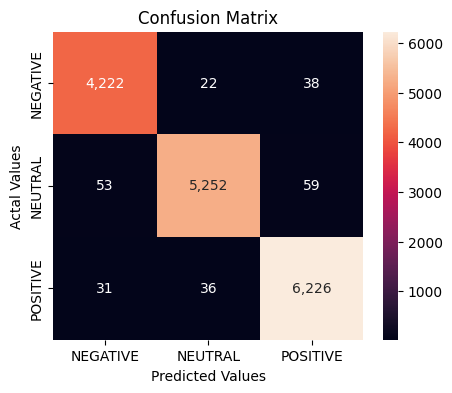

   Label     | Precision  |    Recall    |   Fscore  
-------------------------------------------------------
  Negative   |   0.9805   |    0.9860    |   0.9832  
  Neutral    |   0.9891   |    0.9791    |   0.9841  
  Positive   |   0.9847   |    0.9894    |   0.9870  
-------------------------------------------------------
Accuracy: 98.50%


In [239]:
y_pred = model_predict(bert_classifier, val_dataloader)
display_confusion_matrix(y_pred, y_val)

# Evaluate the classifier
precision, recall, fscore, support = score(y_val, y_pred)

print(f"{'Label':^12} | {'Precision':^10} | {'Recall':^12} | {'Fscore':^10}")
print("-"*55)
sentiments = ['Negative', 'Neutral', 'Positive']

for i in range(len(precision)):
    print(f"{sentiments[i]:^12} | {precision[i]:^10.4f} | {recall[i]:^12.4f} | {fscore[i]:^10.4f}")
print("-"*55)
print(f'Accuracy: {accuracy_score(y_pred, y_val)*100:.2f}%')

### RoBERTa (unbalanced-class)

In [142]:
MODEL_NAME = "roberta-base"
HIDDEN_LAYER_SIZE = 768
MODEL_SAVE_PATH = MODEL_PATH_ROOT + '-' + MODEL_NAME + '.pt'

train_dataloader, val_dataloader, y_val = get_data_loaders(df, MODEL_NAME)

set_seed(42)    # Set seed for reproducibility
roberta_classifier, optimizer, scheduler = initialize_model(MODEL_NAME, HIDDEN_LAYER_SIZE, epochs=2)
train(roberta_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

#### Prediction

In [37]:
y_pred = model_predict(roberta_classifier, val_dataloader)
display_confusion_matrix(y_pred, y_val)

# Evaluate the classifier
print(f'Accuracy: {accuracy_score(y_pred, y_val)*100:.2f}%')

Accuracy: 98.67%


#### r/apple & r/android

In [72]:
android_df = pd.read_csv('android_submissions.csv')
apple_df = pd.read_csv('apple_submissions.csv')

In [76]:
dtypes = {
  "title": "string",
  "created_utc": np.int64,
}
android_df = android_df.astype(dtypes)
apple_df = apple_df.astype(dtypes)
apple_df['date'] = apple_df['created_utc'].apply(lambda x : datetime.utcfromtimestamp(x).strftime("%m/%d/%y"))
android_df['date'] = android_df['created_utc'].apply(lambda x : datetime.utcfromtimestamp(x).strftime("%m/%d/%y"))

In [82]:
android_df

,title,created_utc,date
0,G1 will be the phone from T-Mobile,1219865042,08/27/08
1,Are These the Preloaded Apps for G1?,1219934322,08/28/08
2,Engadget * Engadget Search * RSS Fe...,1220364251,09/02/08
3,HTC's Android-driven Dream revealed in gloriou...,1220364283,09/02/08
4,Google names Android Developer Challenge winners,1220367335,09/02/08
...,...,...,...
761836,I need help with my redmi 10,1672527114,12/31/22
761837,Why do companies release android phones with p...,1672528547,12/31/22
761838,Oppo Find N2 Review: A Foldable With Wide Appeal,1672528727,12/31/22
761839,Your Memories. Their Cloud. - The New York Times,1672529115,12/31/22


In [85]:
filtered_apple_df = apple_df[(apple_df['date'] >= '09/01/22') & (apple_df['date'] <= '09/30/22')]
filtered_android_df = android_df[(android_df['date'] >= '09/01/22') & (android_df['date'] <= '09/30/22')]

In [87]:
print(f"# of testing samples in r/android for Sep'22 : {len(filtered_android_df)}")
print(f"# of testing samples in r/apple for Sep'22 : {len(filtered_apple_df)}")

# of testing samples in r/android for Sep'22 : 65713
# of testing samples in r/apple for Sep'22 : 99563


In [88]:
#Sampling 5000 posts randomly from both subreddits
N_SAMPLES = 5000
test_apple = filtered_apple_df.sample(N_SAMPLES)
test_android = filtered_android_df.sample(N_SAMPLES)

In [89]:
# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
test_inputs_apple, test_masks_apple = preprocessing_for_bert(test_apple.title)
test_inputs_android, test_masks_android = preprocessing_for_bert(test_android.title)

Tokenizing data...


In [90]:
# Create the DataLoader for our testing set
test_data_apple = TensorDataset(test_inputs_apple, test_masks_apple)
test_sampler_apple = RandomSampler(test_data_apple)
test_dataloader_apple = DataLoader(test_data_apple, sampler=test_sampler_apple, batch_size=32)

In [91]:
# Create the DataLoader for our testing set
test_data_android = TensorDataset(test_inputs_android, test_masks_android)
test_sampler_android = RandomSampler(test_data_android)
test_dataloader_android = DataLoader(test_data_android, sampler=test_sampler_android, batch_size=32)

In [92]:
# Compute predicted labels on the test set
y_preds_apple = bert_predict(bert_classifier, test_dataloader_apple)
y_preds_android = bert_predict(bert_classifier, test_dataloader_android)

In [93]:
np.unique(y_preds_apple, return_counts=True)

(array([0, 1, 2]), array([ 814, 2984, 1202]))

In [94]:
np.unique(y_preds_android, return_counts=True)

(array([0, 1, 2]), array([ 674, 2849, 1477]))

## Modeling after handling class imbalance

In [31]:
MODEL_PATH_ROOT = 'reddit_sentiment_balanced'
MAX_LEN = 256

### Bert (balanced-class)

#### Training

In [189]:
MODEL_NAME = "bert-base-uncased"
HIDDEN_LAYER_SIZE = 768
MODEL_SAVE_PATH = MODEL_PATH_ROOT + '-' + MODEL_NAME + '.pt'

train_dataloader, val_dataloader, y_val = get_data_loaders(df_balanced, MODEL_NAME)

set_seed(42)    # Set seed for reproducibility
bert_classifier_balanced, optimizer, scheduler = initialize_model(MODEL_NAME, HIDDEN_LAYER_SIZE, epochs=2)
train(bert_classifier_balanced, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Tokenizing data...
Start training with total batches 10585

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/Users/adityatodi/miniforge3/envs/ds_proj/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/10585 [00:00<?, ?it/s]

   1    |   200   |   0.491189   |     -      |     -     |  108.06  
   1    |   400   |   0.397905   |     -      |     -     |  215.09  
   1    |   600   |   0.356859   |     -      |     -     |  322.94  
   1    |   800   |   0.328866   |     -      |     -     |  430.58  
   1    |  1000   |   0.307307   |     -      |     -     |  537.39  
   1    |  1200   |   0.289740   |     -      |     -     |  643.88  
   1    |  1400   |   0.276223   |     -      |     -     |  750.58  
   1    |  1600   |   0.266688   |     -      |     -     |  857.02  
   1    |  1800   |   0.255308   |     -      |     -     |  965.41  
   1    |  2000   |   0.246335   |     -      |     -     |  1074.19 
   1    |  2200   |   0.239063   |     -      |     -     |  1183.03 
   1    |  2400   |   0.231107   |     -      |     -     |  1291.92 
   1    |  2600   |   0.225215   |     -      |     -     |  1400.82 
   1    |  2800   |   0.218289   |     -      |     -     |  1509.67 
   1    |  3000   | 

  0%|          | 0/10585 [00:00<?, ?it/s]

   2    |   200   |   0.033337   |     -      |     -     |  108.88  
   2    |   400   |   0.038504   |     -      |     -     |  217.47  
   2    |   600   |   0.038572   |     -      |     -     |  325.97  
   2    |   800   |   0.041558   |     -      |     -     |  434.78  
   2    |  1000   |   0.041271   |     -      |     -     |  543.23  
   2    |  1200   |   0.041965   |     -      |     -     |  652.45  
   2    |  1400   |   0.044182   |     -      |     -     |  760.79  
   2    |  1600   |   0.045785   |     -      |     -     |  869.30  
   2    |  1800   |   0.046047   |     -      |     -     |  976.63  
   2    |  2000   |   0.045700   |     -      |     -     |  1083.80 
   2    |  2200   |   0.045578   |     -      |     -     |  1191.94 
   2    |  2400   |   0.045807   |     -      |     -     |  1300.15 
   2    |  2600   |   0.045861   |     -      |     -     |  1408.14 
   2    |  2800   |   0.044603   |     -      |     -     |  1516.37 
   2    |  3000   | 

#### Loading Model

In [39]:
MODEL_NAME = "bert-base-uncased"
HIDDEN_LAYER_SIZE = 768
MODEL_SAVE_PATH = MODEL_PATH_ROOT + '-' + MODEL_NAME + '.pt'

train_dataloader, val_dataloader, y_val = get_data_loaders(df_balanced, MODEL_NAME)
bert_classifier_balanced = Classifier(MODEL_NAME, HIDDEN_LAYER_SIZE, freeze_model=False)

bert_classifier_balanced.load_state_dict(torch.load(MODEL_SAVE_PATH))
bert_classifier_balanced.eval()
bert_classifier_balanced.to(device)

Tokenizing data...


Classifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

#### Evaluation

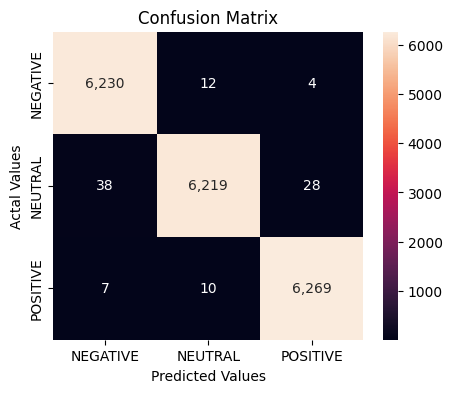

   Label     | Precision  |    Recall    |   Fscore  
-------------------------------------------------------
  Negative   |   0.9928   |    0.9974    |   0.9951  
  Neutral    |   0.9965   |    0.9895    |   0.9930  
  Positive   |   0.9949   |    0.9973    |   0.9961  
-------------------------------------------------------
Accuracy: 99.47%


In [40]:
y_pred = model_predict(bert_classifier_balanced, val_dataloader)
display_confusion_matrix(y_pred, y_val)

# Evaluate the classifier
precision, recall, fscore, support = score(y_val, y_pred)

print(f"{'Label':^12} | {'Precision':^10} | {'Recall':^12} | {'Fscore':^10}")
print("-"*55)
sentiments = ['Negative', 'Neutral', 'Positive']

for i in range(len(precision)):
    print(f"{sentiments[i]:^12} | {precision[i]:^10.4f} | {recall[i]:^12.4f} | {fscore[i]:^10.4f}")

print("-"*55)
print(f'Accuracy: {accuracy_score(y_pred, y_val)*100:.2f}%')

### RoBERTa (balanced-class)

#### Training

In [41]:
MODEL_NAME = "roberta-base"
HIDDEN_LAYER_SIZE = 768
MODEL_SAVE_PATH = MODEL_PATH_ROOT + '-' + MODEL_NAME + '.pt'

train_dataloader, val_dataloader, y_val = get_data_loaders(df_balanced, MODEL_NAME)

set_seed(42)    # Set seed for reproducibility
roberta_classifier_balanced, optimizer, scheduler = initialize_model(MODEL_NAME, HIDDEN_LAYER_SIZE, epochs=2)
train(roberta_classifier_balanced, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Tokenizing data...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start training with total batches 10585

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/Users/adityatodi/miniforge3/envs/ds_proj/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/10585 [00:00<?, ?it/s]

   1    |   200   |   0.583079   |     -      |     -     |  109.27  
   1    |   400   |   0.495341   |     -      |     -     |  217.57  
   1    |   600   |   0.450253   |     -      |     -     |  330.36  
   1    |   800   |   0.421474   |     -      |     -     |  437.11  
   1    |  1000   |   0.397509   |     -      |     -     |  542.82  
   1    |  1200   |   0.380950   |     -      |     -     |  649.71  
   1    |  1400   |   0.363245   |     -      |     -     |  757.12  
   1    |  1600   |   0.349718   |     -      |     -     |  871.63  
   1    |  1800   |   0.337802   |     -      |     -     |  980.04  
   1    |  2000   |   0.326831   |     -      |     -     |  1088.36 
   1    |  2200   |   0.319186   |     -      |     -     |  1196.43 
   1    |  2400   |   0.311663   |     -      |     -     |  1304.81 
   1    |  2600   |   0.304148   |     -      |     -     |  1413.68 
   1    |  2800   |   0.297660   |     -      |     -     |  1522.45 
   1    |  3000   | 

  0%|          | 0/10585 [00:00<?, ?it/s]

   2    |   200   |   0.085711   |     -      |     -     |  118.59  
   2    |   400   |   0.085397   |     -      |     -     |  234.36  
   2    |   600   |   0.086513   |     -      |     -     |  347.62  
   2    |   800   |   0.082657   |     -      |     -     |  459.39  
   2    |  1000   |   0.086590   |     -      |     -     |  571.22  
   2    |  1200   |   0.087541   |     -      |     -     |  682.46  
   2    |  1400   |   0.086043   |     -      |     -     |  793.36  
   2    |  1600   |   0.087279   |     -      |     -     |  904.54  
   2    |  1800   |   0.084508   |     -      |     -     |  1015.68 
   2    |  2000   |   0.084636   |     -      |     -     |  1127.89 
   2    |  2200   |   0.085086   |     -      |     -     |  1241.26 
   2    |  2400   |   0.085136   |     -      |     -     |  1352.60 
   2    |  2600   |   0.083824   |     -      |     -     |  1465.39 
   2    |  2800   |   0.082773   |     -      |     -     |  1580.15 
   2    |  3000   | 

#### Evaluation

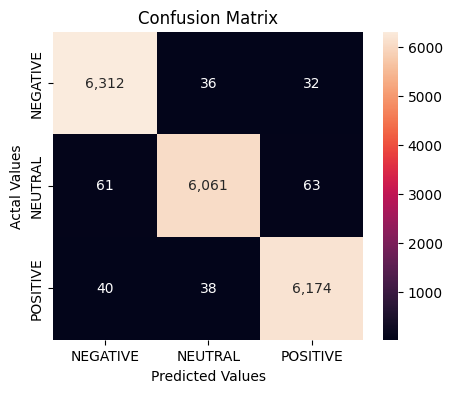

   Label     | Precision  |    Recall    |   Fscore  
-------------------------------------------------------
  Negative   |   0.9843   |    0.9893    |   0.9868  
  Neutral    |   0.9879   |    0.9800    |   0.9839  
  Positive   |   0.9848   |    0.9875    |   0.9862  
-------------------------------------------------------
Accuracy: 98.57%


In [42]:
y_pred = model_predict(roberta_classifier_balanced, val_dataloader)
display_confusion_matrix(y_pred, y_val)

# Evaluate the classifier
precision, recall, fscore, support = score(y_val, y_pred)

print(f"{'Label':^12} | {'Precision':^10} | {'Recall':^12} | {'Fscore':^10}")
print("-"*55)
sentiments = ['Negative', 'Neutral', 'Positive']

for i in range(len(precision)):
    print(f"{sentiments[i]:^12} | {precision[i]:^10.4f} | {recall[i]:^12.4f} | {fscore[i]:^10.4f}")

print("-"*55)
print(f'Accuracy: {accuracy_score(y_pred, y_val)*100:.2f}%')